In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read the data'
test_data = pd.read_parquet('/content/drive/MyDrive/Recomendation/test.parquet')
folder_path = '/content/drive/MyDrive/recommendation'
val_data = pd.read_parquet('/content/drive/MyDrive/Recomendation/val.parquet')
file_path = '/content/drive/MyDrive/Recomendation/train.parquet'
df = pd.read_parquet(file_path)

In [4]:
# Preprocessing Data
def clean_data(data):
    # Drop unnecessary columns
    data.drop(['event_time', 'timestamp', 'cat_3'], axis=1, inplace=True)

    # Drop rows with missing values in 'user_session'
    data.dropna(subset=['user_session'], inplace=True)

    # Drop duplicate rows
    data.drop_duplicates(inplace=True)

    # Replace NA values in categorical columns
    data['cat_0'].replace('NA', 'Unknown', inplace=True)
    data['cat_1'].replace('NA', 'Unknown', inplace=True)
    data['cat_2'].replace('NA', 'Unknown', inplace=True)

    # Convert 'price' column to float
    data['price'] = data['price'].astype(float)

    # Label encoding for string columns
    string_columns = ['event_type', 'product_id', 'brand', 'user_id', 'user_session', 'cat_0', 'cat_1', 'cat_2']
    encoder = LabelEncoder()
    for col in string_columns:
        data[col] = encoder.fit_transform(data[col])

    return data

In [5]:
# Clean test data
test_data_cleaned = clean_data(test_data)

In [6]:
# Clean validation data
val_data_cleaned = clean_data(val_data)

In [7]:
# Clean train data
df = clean_data(df)

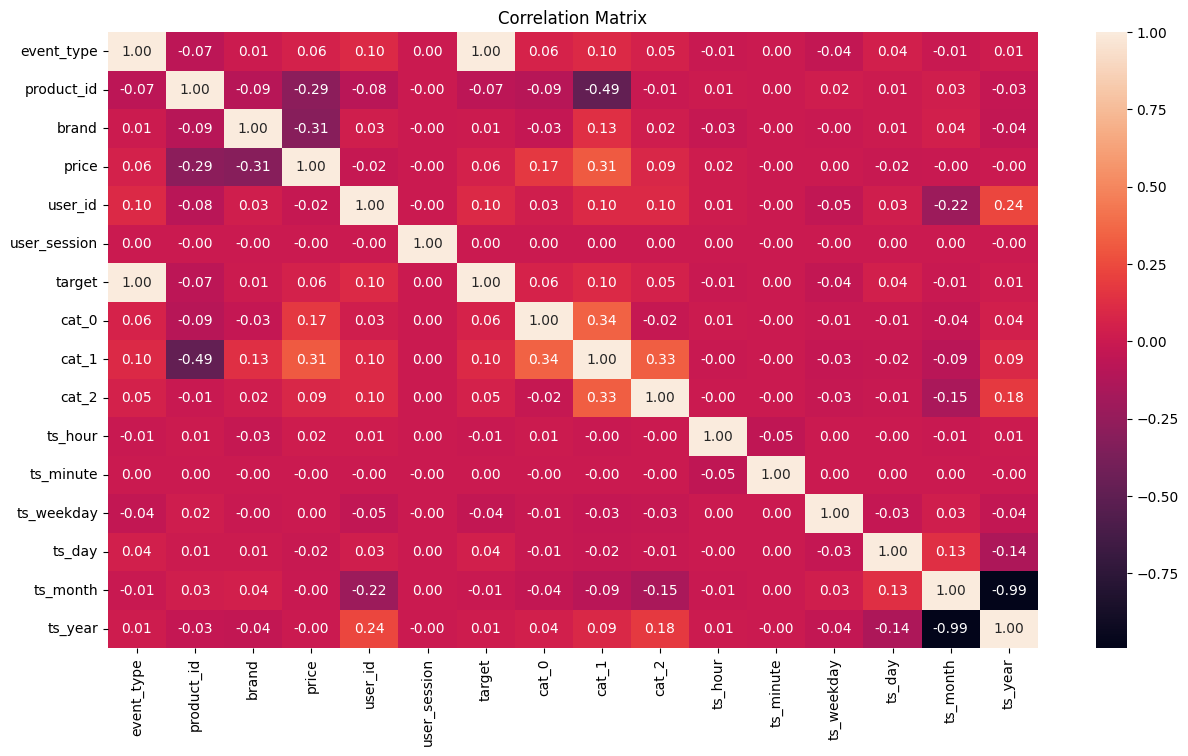

In [8]:
# Exploratory Data Analysis
corr = df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

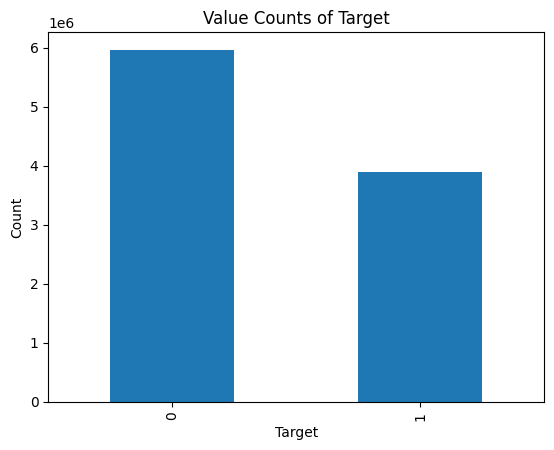

In [9]:
df['target'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Value Counts of Target')
plt.show()

In [10]:
# Split the data into input features and target variable
X = df.drop('target', axis=1)
y = df['target']

In [11]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Scale numerical features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(val_data_cleaned.drop('target', axis=1))
X_test_scaled = scaler.transform(test_data_cleaned.drop('target', axis=1))


In [13]:
# Define the DL model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the checkpoint path
checkpoint_path = 'model_checkpoint.h5'

# Create a ModelCheckpoint callback to save the model with the best validation accuracy
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Fit the model to the training data with the ModelCheckpoint callback
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=1032, validation_data=(X_val_scaled, val_data_cleaned['target']), callbacks=[checkpoint])

Epoch 1/10
7629/7639 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9988
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to model_checkpoint.h5
7639/7639 [==============================] - 46s 5ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 9.3529e-07 - val_accuracy: 1.0000
Epoch 2/10
7638/7639 [============================>.] - ETA: 0s - loss: 6.7634e-08 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
7639/7639 [==============================] - 38s 5ms/step - loss: 6.7631e-08 - accuracy: 1.0000 - val_loss: 3.0803e-08 - val_accuracy: 1.0000
Epoch 3/10
7635/7639 [============================>.] - ETA: 0s - loss: 4.1367e-09 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
7639/7639 [==============================] - 37s 5ms/step - loss: 4.1360e-09 - accuracy: 1.0000 - val_loss: 8.2468e-09 - val_accuracy: 1.0000
Epoch 4/10
7638/7639 [============================>.] - ETA: 0s - loss: 2.0212e-09 - 

In [14]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('model_checkpoint.h5')


In [15]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)  

# Evaluate the predictions
precision = precision_score(test_data_cleaned['target'], y_pred_binary)
recall = recall_score(test_data_cleaned['target'], y_pred_binary)
f1 = f1_score(test_data_cleaned['target'], y_pred_binary)
auc_roc = roc_auc_score(test_data_cleaned['target'], y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


77780/77780 [==============================] - 132s 2ms/step
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
AUC-ROC: 1.0000
